<a href="https://colab.research.google.com/github/ctorney/learning-to-simulate-tf2/blob/main/Copy_of_fish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preliminaries

In [ ]:
!pip install spektral

In [ ]:
#@title ### Imports { form-width: "30%" }

import os, sys
import numpy as np
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import datetime
import json

import tensorflow as tf

from scipy import stats

import pickle

import functools
from tqdm import tqdm

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import tensorflow_probability as tfp

from spektral.layers import ECCConv, GlobalAvgPool, MessagePassing, XENetConv, GlobalAttentionPool, GlobalMaxPool, GlobalSumPool,GlobalAttnSumPool
tfpl = tfp.layers
tfd = tfp.distributions

plt.style.use('ggplot')
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid')

In [ ]:
#@title ### Data { form-width: "30%" }

with open('schooling_frames.json') as json_file:
    data = json.load(json_file)

data_as_list = []
for d in data.keys():
    data_as_list.append(data[d])

In [ ]:
#@title ### Metadata { form-width: "30%" }
n_frames = len(data_as_list)
max_n = 0
min_n = 1000000
for d in data_as_list:
    if len(d['px'])> max_n: max_n = len(d['px'])
    if len(d['px'])< min_n: min_n = len(d['px'])

max_id = 0
min_id = 10000000
for d in data_as_list:
    for i in d['onfish']:
        if i> max_id: max_id = i
        if i< min_id: min_id = i

total_id = max_id-min_id+1

print(f'max_n = {max_n}, min_n = {min_n}, max_id = {max_id}, min_id = {min_id}, total_id = {total_id}')

max_n = 289, min_n = 87, max_id = 112205, min_id = 97196, total_id = 15010


In [ ]:
max_id1 = 0
min_id1 = 10000000
for d in data_as_list:
    print(d['onfish'])
    for i in d['onfish']:
        if i> max_id1: max_id1 = i
        if i< min_id1: min_id1 = i
    break
print(min_id1, max_id1)

[97196, 97975, 98320, 98324, 98372, 98500, 98518, 98604, 98804, 98864, 98940, 99021, 99024, 99027, 99083, 99098, 99152, 99160, 99188, 99217, 99258, 99263, 99341, 99343, 99372, 99398, 99404, 99429, 99430, 99431, 99436, 99439, 99458, 99461, 99462, 99464, 99471, 99476, 99485, 99497, 99516, 99523, 99525, 99529, 99547, 99553, 99558, 99559, 99573, 99583, 99596, 99601, 99606, 99616, 99631, 99635, 99636, 99638, 99646, 99649, 99657, 99661, 99662, 99663, 99677, 99692, 99694, 99699, 99702, 99718, 99720, 99736, 99741, 99746, 99752, 99754, 99755, 99758, 99768, 99770, 99771, 99777, 99778, 99779, 99780, 99793, 99794, 99805, 99814, 99820, 99822, 99823, 99830, 99834, 99837, 99844, 99850, 99852, 99855, 99857, 99860, 99868, 99876, 99878, 99880, 99883, 99884, 99885, 99892, 99898, 99899, 99901, 99911, 99912, 99919, 99920, 99930, 99934, 99941, 99942, 99943, 99950, 99953, 99956, 99960, 99967, 99976, 99980, 99981, 99984, 99985, 99989, 99992, 99993, 99996, 100003, 100004, 100006, 100011, 100013, 100014, 100016

In [ ]:
#@title ### Datatypes { form-width: "30%" }

for d in data_as_list:
    for key in d.keys():
        if key=='onfish':
            pass
        else:
            for i in range(len(d[key])):
                if d[key][i]==None: d[key][i]=np.nan
                d[key][i] = float(d[key][i])

In [ ]:
#@title ### Plotting Data { form-width: "30%" }

plot_pos = np.zeros((n_frames,max_n, 2))
plot_vel = np.zeros((n_frames,max_n, 2))
ns = np.zeros(n_frames)

for i in range(n_frames):
    thisn = len(data_as_list[i]['px'])
    ns[i] = thisn
    thisposx = data_as_list[i]['px']
    thisposy = data_as_list[i]['py']
    thisvelx = data_as_list[i]['vx']
    thisvely = data_as_list[i]['vy']
    
    plot_pos[i,:thisn,0]=thisposx
    plot_pos[i,:thisn,1]=thisposy
    plot_vel[i,:thisn,0]=thisvelx
    plot_vel[i,:thisn,1]=thisvely

# Animation

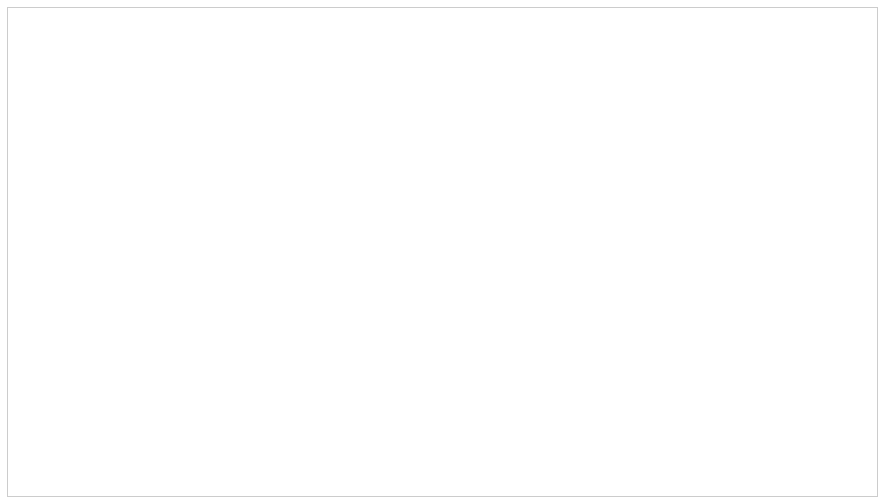

In [ ]:
#@title ### Animation Code { form-width: "30%" }

step_stride = 10
block_on_show = True

fig, axes = plt.subplots(1, 1, figsize=(16, 9))

plot_info = []
Q={}

ax_i = 1
ax = axes#[ax_i]

bounds = [(0,1920), (0,1080)]
ax.set_xlim(bounds[0][0], bounds[0][1])
ax.set_ylim(bounds[1][0], bounds[1][1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect(1.)
    
X, Y = plot_pos[0,:,0],plot_pos[0,:,1]
U, V = plot_vel[0,:,0],plot_vel[0,:,1]


In [ ]:
#@title ### Generate Animation { form-width: "30%" }

Q[f'{ax_i}'] = ax.quiver(X, Y, U, V, pivot='mid', color='b', units='inches')

num_steps = len(data_as_list)
#print(pos_trajectory.shape)

def update_quiver(num):

    U, V = plot_vel[num,:,0],plot_vel[num,:,1]
    offsets  = plot_pos[num]
    #Q[f'{ax_i}'] = ax.quiver(X, Y, U, V, pivot='mid', color='b', units='inches')
    #offsets  = np.asarray(offsets).T
    Q[f'{ax_i}'].set_offsets(offsets)
    Q[f'{ax_i}'].set_UVC(U,V)
    return axes

anim = animation.FuncAnimation(fig, update_quiver, interval=50, frames=np.arange(0, num_steps, step_stride),blit=False)
#plt.show(block=block_on_show)
rc('animation', html='jshtml')
anim


#Preprocessing

In [ ]:
#@title ### Create Full Array { form-width: "30%" }

pos = np.zeros((n_frames,total_id, 2))
vel = np.zeros((n_frames,total_id, 2))
pos[...] = np.nan
vel[...] = np.nan

for i in range(n_frames):
    thisn = ns[i]
    thisindices = np.array([c - min_id for c in data_as_list[i]['onfish']])
    thisposx = data_as_list[i]['px']
    thisposy = data_as_list[i]['py']
    thisvelx = data_as_list[i]['vx']
    thisvely = data_as_list[i]['vy']
    
    pos[i,thisindices,0]=np.array(thisposx)
    pos[i,thisindices,1]=np.array(thisposy)
    vel[i,thisindices,0]=np.array(thisvelx)
    vel[i,thisindices,1]=np.array(thisvely)

# data_dicts = [{'pos':pos,
#                'vel':vel}]

In [ ]:
ns[0]

253.0

In [ ]:
difflist = [np.count_nonzero(~np.isnan(pos[i,:,0]))-ns[i] for i in range(5000)]
np.sum(difflist)

0.0

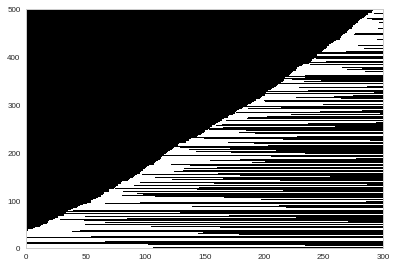

In [ ]:
pos_c = np.where(np.isnan(pos), 1, 0)
fig, ax = plt.subplots()
ax.pcolormesh(np.matrix.transpose(pos_c[4700:,14500:15000,0]))

In [ ]:
pos_c[:100,200:400,0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
print(data_as_list[397]['onfish'][0]-min_id)

1828


In [ ]:
np.count_nonzero(~np.isnan(pos[50,0,:]))

2

In [ ]:
batches = np.zeros((4998))
for i in range(4998):
    arr = pos[i:i+2]
    ind = np.any(np.isnan(arr), axis=(0,2))
    arr[:,ind,:]=np.nan
    batches[i] = np.count_nonzero(~np.isnan(arr))/4
print(batches)
print(ind)
print(ns)

[237. 234. 229. ...   0.   0.   0.]
[ True  True  True ...  True  True  True]
[253. 251. 251. ... 261. 261. 262.]


In [ ]:
np.count_nonzero(np.isnan(pos[0:2,]))

59092

In [ ]:
#@title ### Parsing Functions { form-width: "30%" }

WINDOW_SIZE=3
DOMAIN_SIZE=(1920,1080)

def make_window_dataset(x, y):
    # make a dataset from the time series tensor
    windows = tf.data.Dataset.from_tensor_slices((x, y))
    # convert to windows
    windows = windows.window(WINDOW_SIZE, shift=1, stride=1)
    # take a batch of window size and combine pos, vel to a single dataset
    windows = windows.flat_map(lambda pos_ds,vel_ds: tf.data.Dataset.zip((pos_ds.batch(WINDOW_SIZE, drop_remainder=True),vel_ds.batch(WINDOW_SIZE, drop_remainder=True))))
    return windows


def split_targets(x, y, w=WINDOW_SIZE):
    inputs = (x[0:w-1], y[0:w-1])
    targets = y[None,-1]
    return (inputs, targets)

split_with_window = functools.partial(
  split_targets,
  w=WINDOW_SIZE)

def reduce_windows(x, y):
    indices = tf.where(tf.math.logical_not(tf.reduce_any(tf.math.logical_or(tf.math.is_nan(x), tf.math.is_nan(y)), axis=(0,2))))[:,0]
    #print('indices', indices)
    x = tf.gather(x, indices, axis=1)
    y = tf.gather(y, indices, axis=1)
    #print('x2', x)
    return tf.data.Dataset.from_tensors((x, y))



In [ ]:
#@title ### Parse Graph Function { form-width: "30%"}
#@markdown Edge distance not normalised to L

def pre_process_function(X, V, _Lx=DOMAIN_SIZE[0], _Ly=DOMAIN_SIZE[1], train_mode=True, add_noise=True):
        
        #X, V = inputs
        # input shape [batch, steps, num. agents, dims]
        # node features xpos, ypos, xvel, yvel
        # edge features distance, rel angle to receiver
        X_current = X[:,-1]
        V_current = V[:,-1]
        print(X_current.shape)

        Xx = tf.expand_dims(X_current[...,0],-1)
        dx = -Xx + tf.linalg.matrix_transpose(Xx)
        dx = tf.where(dx>0.5*_Lx, dx-_Lx, dx)
        dx = tf.where(dx<-0.5*_Lx, dx+_Lx, dx)
        #x_boundary_dist = tf.concat([Xx, _L-Xx], axis=-1)

        Xy = tf.expand_dims(X_current[...,1],-1)
        dy = -Xy + tf.linalg.matrix_transpose(Xy)
        dy = tf.where(dy>0.5*_Ly, dy-_Ly, dy)
        dy = tf.where(dy<-0.5*_Ly, dy+_Ly, dy)
        #y_boundary_dist = tf.concat([Xy, _L-Xy], axis=-1)

        #boundary_dist = tf.concat([x_boundary_dist, y_boundary_dist], axis=-1)

        Vx = tf.expand_dims(V_current[...,0],-1)
        dvx = -Vx + tf.linalg.matrix_transpose(Vx)

        Vy = tf.expand_dims(V_current[...,1],-1)
        dvy = -Vy + tf.linalg.matrix_transpose(Vy)
        
        dvnorm = tf.math.sqrt(dvx**2+dvy**2)
        dvx = tf.math.divide_no_nan(dvx,dvnorm)
        dvy = tf.math.divide_no_nan(dvy,dvnorm)

        angles = tf.expand_dims(tf.math.atan2(V_current[...,1],V_current[...,0]),-1)
        angle_to_neigh = tf.math.atan2(dy, dx)

        rel_angle_to_neigh = angle_to_neigh - angles

        dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

        interaction_radius = 25.0# tf.reduce_mean(dist,axis=[1,2],keepdims=True)
        adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
        adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
        sender_recv_list = tf.where(adj_matrix)
        n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
        n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]
        output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)

        senders = tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
        receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

        output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
        edge_distance = tf.expand_dims(tf.gather_nd(dist,sender_recv_list),-1)
        #print("ed", edge_distance.shape)
        edge_x_distance = tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_y_distance = tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_x_orientation = tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
        edge_y_orientation = tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


        output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)
        #edges = tf.concat([edge_distance,edge_x_distance,edge_y_distance],axis=-1)
        node_velocities = tf.transpose(V, perm=[0,2,1,3])
        #node_accelerations = tf.transpose(A, perm=[0,2,1,3])

        return output_x, output_a, output_e#, output_i

ppfunc = functools.partial(pre_process_function,
                           _Lx=DOMAIN_SIZE[0],
                           _Ly=DOMAIN_SIZE[1]
                           )

In [ ]:
#@title ### Naive Parse Graph Function { form-width: "30%"}
#@markdown Edge distance not normalised to L

def naive_pre_process_function(X, V, _Lx=DOMAIN_SIZE[0], _Ly=DOMAIN_SIZE[1], train_mode=True, add_noise=True):
        
        #X, V = inputs
        # input shape [batch, steps, num. agents, dims]
        # node features xpos, ypos, xvel, yvel
        # edge features distance, rel angle to receiver
        X_current = X[...,-1]
        V_current = V[...,-1]
        #print(X_current.shape)
        
        def transpose_tensors_pos(i):
            i = i.to_tensor()
            ii = tf.expand_dims(i[...,0], -1)
            dx = tf.linalg.matrix_transpose(ii)-ii
            dx = tf.where(dx>0.5*_Lx, dx-_Lx, dx)
            dx = tf.where(dx<-0.5*_Lx, dx+_Lx, dx)
            dx = tf.RaggedTensor.from_tensor(dx)

            jj = tf.expand_dims(i[...,1], -1)
            dy = tf.linalg.matrix_transpose(jj)-jj
            dy = tf.where(dy>0.5*_Ly, dy-_Ly, dy)
            dy = tf.where(dy<-0.5*_Ly, dy+_Ly, dy)
            dy = tf.RaggedTensor.from_tensor(dy)

            dd = tf.math.sqrt(tf.square(dx)+tf.square(dy))

            return dx, dy, dd

        def transpose_tensors_vel(i):
            i = i.to_tensor()
            ii = tf.expand_dims(i[...,0], -1)
            dx = tf.linalg.matrix_transpose(ii)-ii
            dx = tf.RaggedTensor.from_tensor(dx)

            jj = tf.expand_dims(i[...,1], -1)
            dy = tf.linalg.matrix_transpose(jj)-jj
            dy = tf.RaggedTensor.from_tensor(dy)

            dnorm = tf.math.sqrt(tf.square(dx)+tf.square(dy))

            dx = tf.math.divide_no_nan(dx,dnorm)
            dy = tf.math.divide_no_nan(dy,dnorm)

            return dx, dy

        posdata = tf.map_fn(fn=transpose_tensors_pos,
                          elems=X_current,
                          fn_output_signature=(tf.RaggedTensorSpec(shape=[None, None],
                                                                   ragged_rank=1, 
                                                                   dtype=tf.float64),
                                               tf.RaggedTensorSpec(shape=[None, None], 
                                                                   ragged_rank=1, 
                                                                   dtype=tf.float64),
                                               tf.RaggedTensorSpec(shape=[None, None], 
                                                                   ragged_rank=1, 
                                                                   dtype=tf.float64))
                          )
        
        dx, dy, dist = posdata

        veldata = tf.map_fn(fn=transpose_tensors_vel,
                          elems=V_current,
                          fn_output_signature=(tf.RaggedTensorSpec(shape=[None, None], 
                                                                   ragged_rank=1, 
                                                                   dtype=tf.float64),
                                               tf.RaggedTensorSpec(shape=[None, None], 
                                                                   ragged_rank=1, 
                                                                   dtype=tf.float64))
                          )
        dvx, dvy = veldata

        def angles(x):
            x = x.to_tensor()
            return tf.expand_dims(tf.math.atan2(x[...,1],x[...,0]),-1)

        angles = tf.map_fn(fn=angles,
                           elems=V_current,
                           fn_output_signature=tf.RaggedTensorSpec(shape=[None, None], 
                                                                   ragged_rank=0, 
                                                                   dtype=tf.float64)
                           )
        angle_to_neigh = tf.math.atan2(dy, dx)

        rel_angle_to_neigh = angle_to_neigh - angles

        #dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

        interaction_radius = 25.0# tf.reduce_mean(dist,axis=[1,2],keepdims=True)
        
        def set_diag_func(x):
            x = x.to_tensor()
            x = tf.linalg.set_diag(x, tf.zeros(tf.shape(x)[0],dtype=tf.int32))
            return tf.RaggedTensor.from_tensor(x)
        
        adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
        #adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
        adj_matrix = tf.map_fn(fn=set_diag_func,
                               elems=adj_matrix,
                               fn_output_signature=(tf.RaggedTensorSpec(shape=[None,None],
                                                                        ragged_rank=1, 
                                                                        dtype=tf.int32)))
        
        sender_recv_list = tf.where(adj_matrix)
        n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
        #print('sr list', sender_recv_list)
        # def count_nodes(x):
        #     return tf.shape(x)[-1]

        # #n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]
        # n_node = tf.map_fn(fn=count_nodes,
        #                    elems=adj_matrix,
        #                    fn_output_signature=tf.RaggedTensorSpec(shape=[None,None], ragged_rank=1, dtype=tf.int32))
        n_node = adj_matrix.row_lengths(axis=1)
        #print(tf.range(adj_matrix.get_shape()[0]))
        #output_i = tf.repeat(tf.range(adj_matrix.get_shape()[0]),n_node)

        # Finds batch indices (s1) for each edge and multiplies by 
        # the number of nodes in each graph (n_node) to determine the 
        # shift along the sparse matrix axes for sender and receiver indices

        s1 = tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))
        s2 = tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))
        s3 = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1)))
        # print('s1, s2, s3', s1.shape, s2.shape, s3.shape)
        # print('nodes', n_node)#.shape)

        def indice_func(n):
            return n_node[n]
        
        indice_update = tf.map_fn(fn=indice_func,
                                  elems=s1
                                  #fn_output_signature=
                                  )
        senders = s2 + indice_update
        receivers = s3 + indice_update

        # def send_func(n):
        #     return s2 + s1*n
      
        # def rec_func(n):
        #     return s3 + s1*n
        
        # senders = tf.map_fn(fn=send_func,
        #                     elems=n_node,
        #                     fn_output_signature=tf.TensorSpec(shape=[None], dtype=tf.int64)
        #                     )
        # receivers = tf.map_fn(fn=send_func,
        #                     elems=n_node,
        #                     fn_output_signature=tf.TensorSpec(shape=[None], dtype=tf.int64)
        #                     )
        #print(senders.shape)
        # senders = tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*n_node
        # receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
        total_nodes = tf.reduce_sum(n_node, axis=0)
        output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[total_nodes, total_nodes])
        edge_distance = tf.expand_dims(tf.gather_nd(dist,sender_recv_list),-1)
        #print("ed", edge_distance.shape)
        edge_x_distance = tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_y_distance = tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_x_orientation = tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
        edge_y_orientation = tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


        output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)
        #edges = tf.concat([edge_distance,edge_x_distance,edge_y_distance],axis=-1)
        #node_velocities = tf.transpose(V, perm=[0,2,1,3])
        def vel_transpose_func(x):
            x = x.to_tensor()
            x = tf.transpose(x, perm=[1,0,2])
            return tf.reshape(x, (-1, 2*(WINDOW_SIZE-1)))
        #print(V.shape)
        node_velocities = tf.map_fn(fn=vel_transpose_func,
                                    elems=V,
                                    fn_output_signature=tf.RaggedTensorSpec(shape=[None, None],
                                                                            ragged_rank=0, 
                                                                            dtype=tf.float64),
                                    infer_shape=False
                                    )

        #node_accelerations = tf.transpose(A, perm=[0,2,1,3])
        output_x = node_velocities.merge_dims(0,1)

        return output_x, output_a, output_e#, output_i

naive_ppfunc = functools.partial(naive_pre_process_function,
                           _Lx=DOMAIN_SIZE[0],
                           _Ly=DOMAIN_SIZE[1]
                           )

In [ ]:
b=0
parsed_train_dataset = make_window_dataset(pos, vel)
for i, (x,y) in enumerate(parsed_train_dataset):
    a = tf.where(tf.math.logical_not(tf.reduce_any(tf.math.logical_or(tf.math.is_nan(x), tf.math.is_nan(y)), axis=(0,2))))[:,0]
    if i==b:break
# print(tf.math.reduce_sum(tf.cast(tf.math.logical_not(tf.reduce_all(tf.math.is_nan(y), axis=(0,2))),tf.float32)))
# print(tf.math.reduce_sum(tf.cast(tf.math.logical_not(tf.reduce_all(tf.math.logical_or(tf.math.is_nan(x), tf.math.is_nan(y)), axis=(0,2))),tf.float32)))
index=3044
print(tf.reduce_any(tf.math.logical_or(tf.math.is_nan(x), tf.math.is_nan(y)),axis=[0,2])[index])
print(tf.math.logical_or(tf.math.is_nan(x), tf.math.is_nan(y))[:,index,:])
print(x[:,index,:])
print(a)
print(ns[b])
#print(pos[b,:,:][a])
#print(tf.math.is_nan(pos[b,:,:][a]))

In [ ]:
#@title ### Create Dataset { form-width: "30%"}

n_out = 2
n_feat_node = (WINDOW_SIZE-1)*4+2
n_feat_edge = 5

BATCH_SIZE=128


#parsed_train_dataset = tf.data.Dataset.from_tensor_slices((pos, vel))
parsed_train_dataset = make_window_dataset(pos, vel)
parsed_train_dataset = parsed_train_dataset.flat_map(reduce_windows)
parsed_train_dataset = parsed_train_dataset.map(split_with_window)
# for batch in parsed_train_dataset:
#     print(batch[0].shape)
#     break
parsed_train_dataset = parsed_train_dataset.shuffle(10000, reshuffle_each_iteration=True)
#parsed_train_dataset = parsed_train_dataset.repeat(EPOCHS)
parsed_train_dataset = parsed_train_dataset.apply(tf.data.experimental.dense_to_ragged_batch(BATCH_SIZE, drop_remainder=True))
#parsed_train_dataset = parsed_train_dataset.map(_parse_graph)
# for batch in parsed_train_dataset:
#     #print(naive_ppfunc(batch[0][0], batch[0][1]))
#     print(batch[1].shape)
#     break
parsed_train_dataset = parsed_train_dataset.map(lambda x, y: (naive_ppfunc(x[0], x[1]), y))

#big_list = [batch[0].shape[1]-ns[i] for i, batch in enumerate(parsed_train_dataset)]
# valid_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([valid_dir + filename for filename in os.listdir(valid_dir)]))

# parsed_valid_dataset = valid_dataset.map(_parse_record)
# parsed_valid_dataset = parsed_valid_dataset.map(_parse_tensor)
# parsed_valid_dataset = parsed_valid_dataset.flat_map(make_window_dataset)
# parsed_valid_dataset = parsed_valid_dataset.map(split_with_window)
# parsed_valid_dataset = parsed_valid_dataset.shuffle(10000, reshuffle_each_iteration=True)
# #parsed_valid_dataset = parsed_valid_dataset.repeat(EPOCHS)
# parsed_valid_dataset = parsed_valid_dataset.batch(BATCH_SIZE, drop_remainder=True)
# #parsed_valid_dataset = parsed_valid_dataset.map(_parse_graph)

In [ ]:
big_list

In [ ]:
#@title ### Preprocessing Layer

class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, Ls):
        super(PreprocessingLayer, self).__init__()
        self._Lx = Ls[0]
        self._Ly = Ls[1]
        

    #@tf.function(input_signature=([tf.TensorSpec(shape=(None,WINDOW_SIZE-1,N,2), dtype=tf.float32),tf.TensorSpec(shape=(None,WINDOW_SIZE-1,N,2), dtype=tf.float32),tf.TensorSpec(shape=(None,WINDOW_SIZE-1,N,2), dtype=tf.float32)]))
    def call(self, inputs, train_mode=True, add_noise=True):
        
        X, V = inputs
        # input shape [batch, steps, num. agents, dims]
        # node features xpos, ypos, xvel, yvel
        # edge features distance, rel angle to receiver
        X_current = X[:,-1]
        V_current = V[:,-1]

        Xx = tf.expand_dims(X_current[...,0],-1)
        dx = -Xx + tf.linalg.matrix_transpose(Xx)
        dx = tf.where(dx>0.5*self._Lx, dx-self._Lx, dx)
        dx = tf.where(dx<-0.5*self._Lx, dx+self._Lx, dx)
        #x_boundary_dist = tf.concat([Xx, self._L-Xx], axis=-1)

        Xy = tf.expand_dims(X_current[...,1],-1)
        dy = -Xy + tf.linalg.matrix_transpose(Xy)
        dy = tf.where(dy>0.5*self._Ly, dy-self._Ly, dy)
        dy = tf.where(dy<-0.5*self._Ly, dy+self._Ly, dy)
        #y_boundary_dist = tf.concat([Xy, self._L-Xy], axis=-1)

        #boundary_dist = tf.concat([x_boundary_dist, y_boundary_dist], axis=-1)

        Vx = tf.expand_dims(V_current[...,0],-1)
        dvx = -Vx + tf.linalg.matrix_transpose(Vx)

        Vy = tf.expand_dims(V_current[...,1],-1)
        dvy = -Vy + tf.linalg.matrix_transpose(Vy)
        
        dvnorm = tf.math.sqrt(dvx**2+dvy**2)
        dvx = tf.math.divide_no_nan(dvx,dvnorm)
        dvy = tf.math.divide_no_nan(dvy,dvnorm)

        angles = tf.expand_dims(tf.math.atan2(V_current[...,1],V_current[...,0]),-1)
        angle_to_neigh = tf.math.atan2(dy, dx)

        rel_angle_to_neigh = angle_to_neigh - angles

        dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

        interaction_radius = 25.0# tf.reduce_mean(dist,axis=[1,2],keepdims=True)
        adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
        adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
        sender_recv_list = tf.where(adj_matrix)
        n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
        n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]
        output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)

        senders = tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
        receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

        output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
        edge_distance = tf.expand_dims(tf.gather_nd(dist,sender_recv_list),-1)

        edge_x_distance = tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_y_distance = tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_x_orientation = tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
        edge_y_orientation = tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


        output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)
        node_velocities = tf.transpose(V, perm=[0,2,1,3])

        output_x = tf.reshape(node_velocities,(-1,2*(WINDOW_SIZE-1)))

        return output_x, output_a, output_e, output_i

In [ ]:
#@title ### Model { form-width: "30%" }

min_lr = 1e-6
lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3 - min_lr,
                                decay_steps=int(5e6),
                                decay_rate=0.1) #+ min_lr
MLP_SIZE=4

class GNNNet(Model):
    def __init__(self,n_out=4,mp_steps=2):
        super().__init__()
        #self.preprocess = PreprocessingLayer(DOMAIN_SIZE)
        self.encoder = XENetConv([MLP_SIZE,MLP_SIZE], MLP_SIZE, 2*MLP_SIZE, node_activation="tanh", edge_activation="tanh") #ECCConv(32, activation="tanh")
        
        self.process = XENetConv([MLP_SIZE,MLP_SIZE], MLP_SIZE, 2*MLP_SIZE, node_activation="relu", edge_activation="relu")# MessagePassing(aggregate='mean')# 32, activation="relu")
        
        self.decoder = Dense(tfpl.IndependentNormal.params_size(n_out), activation="tanh",use_bias=False) #ECCConv(n_out, activation="tanh")
        
        self.mean_decoder = Dense(n_out, activation="tanh",use_bias=False) #ECCConv(n_out, activation="tanh")
        self.std_decoder = Dense(n_out, activation="linear",kernel_initializer=tf.keras.initializers.Zeros(),bias_initializer=tf.keras.initializers.Constant(-2.)) #ECCConv(n_out, activation="tanh")

        self.distribution = tfp.layers.IndependentNormal(n_out)#lambda (mu, std): tfd.Normal(loc=mu, scale=std))
        #self.global_pool = GlobalAvgPool()
        #self.dense = Dense(32, activation="relu")
        #self.final = Dense(n_out, activation="sigmoid")
        self.mp_steps=mp_steps
    
    def call(self, inputs, train_mode=True):
        #x, a, e, i = self.preprocess(inputs, train_mode=train_mode)
        #x.set_shape([None,None])
        #print(x.shape, a.shape, e.shape, i.shape)
        x, a, e = inputs
        x, e = self.encoder([x, a, e])
        #x = self.node_encoder(x)
        #e = self.edge_encoder(e)
        for _ in range(self.mp_steps):
            x, e = self.process([x, a, e])         
        mu = self.mean_decoder(x)
        std = self.std_decoder(x)
        x = tf.keras.layers.concatenate([mu,std])
#        x = self.distribution([mu,std])
#        x = self.decoder(x)
        x = self.distribution(x)
        #x = self.global_pool([x, i])
        #x = self.dense(x)
        #x = self.final(x)

        #x = tf.reshape(x, (-1, N, 2))

        return x


model = GNNNet(n_out=n_out)
optimizer = Adam(lr)
loss_fn = MeanSquaredError()

def loss_fn(target,predicted_dist):
    return -tf.reduce_sum(predicted_dist.log_prob(target.merge_dims(0,2)))

In [ ]:
#@title ### Train Step

#@tf.function()#input_signature=[[tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32)],tf.TensorSpec(shape=(None,4), dtype=tf.float32)], experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        #print(predictions.dtype, target.dtype)
        target = tf.cast(target, dtype=tf.float32)
        loss = loss_fn(target, predictions) #+ sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

# def train_step_op(inputs, target):
#     with tf.GradientTape() as tape:
#         predictions = model(inputs, training=True)
#         loss = op_loss(target, predictions) #+ sum(model.losses)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     return loss

In [157]:
#@title ### Train Model { form-width: "30%" }
step = losses = 0
total=len(list(parsed_train_dataset))
epochs = 20  # Number of training epochs
batch_size = BATCH_SIZE  # Batch size
print(f"total = {total}, batch size = {batch_size}")
divisor=20
loss_values = np.zeros((epochs,total))

log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
summary_writer = tf.summary.create_file_writer(logdir=log_dir)

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    pbar = tqdm(enumerate(parsed_train_dataset), total=total)
    
    for step, batch in pbar:
        inputs, target = batch
        #inputs = layer(inputs)
        losses = train_step(inputs,target)
        loss_values[epoch,step]=losses.numpy()
        #epoch_loss_avg(losses)
        #epoch_accuracy(y, model())
        if step%divisor==0:
            pbar.set_description("loss %f" % (tf.reduce_mean(loss_values[epoch,0:step+1]).numpy()))
    
    with summary_writer.as_default():
        tf.summary.scalar('epoch_loss_avg', epoch_loss_avg.result(), step=optimizer.iterations)
        tf.summary.scalar('epoch_accuracy', epoch_accuracy.result(), step=optimizer.iterations)

total = 39, batch size = 128

Start of epoch 0


loss 46551.911458: 100%|██████████| 39/39 [00:11<00:00,  3.52it/s]



Start of epoch 1


loss 45612.728423: 100%|██████████| 39/39 [00:10<00:00,  3.55it/s]



Start of epoch 2


loss 45135.835751: 100%|██████████| 39/39 [00:10<00:00,  3.59it/s]



Start of epoch 3


loss 44577.247954: 100%|██████████| 39/39 [00:11<00:00,  3.53it/s]



Start of epoch 4


loss 43525.099888: 100%|██████████| 39/39 [00:10<00:00,  3.55it/s]



Start of epoch 5


loss 43043.474516: 100%|██████████| 39/39 [00:10<00:00,  3.55it/s]



Start of epoch 6


loss 42358.231213: 100%|██████████| 39/39 [00:11<00:00,  3.51it/s]



Start of epoch 7


loss 41621.457961: 100%|██████████| 39/39 [00:11<00:00,  3.54it/s]



Start of epoch 8


loss 40678.818452: 100%|██████████| 39/39 [00:10<00:00,  3.58it/s]



Start of epoch 9


loss 40102.272693: 100%|██████████| 39/39 [00:10<00:00,  3.56it/s]



Start of epoch 10


loss 39574.529762: 100%|██████████| 39/39 [00:11<00:00,  3.54it/s]



Start of epoch 11


loss 38855.848586: 100%|██████████| 39/39 [00:11<00:00,  3.53it/s]



Start of epoch 12


loss 38155.558222: 100%|██████████| 39/39 [00:11<00:00,  3.50it/s]



Start of epoch 13


loss 37491.828497: 100%|██████████| 39/39 [00:11<00:00,  3.51it/s]



Start of epoch 14


loss 37006.102679: 100%|██████████| 39/39 [00:11<00:00,  3.52it/s]



Start of epoch 15


loss 36157.833333: 100%|██████████| 39/39 [00:11<00:00,  3.51it/s]



Start of epoch 16


loss 35499.269159: 100%|██████████| 39/39 [00:11<00:00,  3.49it/s]



Start of epoch 17


loss 34309.370908: 100%|██████████| 39/39 [00:11<00:00,  3.50it/s]



Start of epoch 18


loss 33423.428757: 100%|██████████| 39/39 [00:11<00:00,  3.48it/s]



Start of epoch 19


loss 32497.857143: 100%|██████████| 39/39 [00:11<00:00,  3.49it/s]


# Outputs/Rollouts

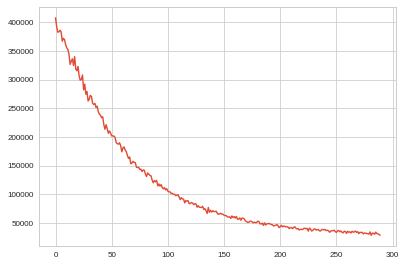

In [ ]:
#@title ### Loss Plot

compression = 10

loss = np.ndarray.flatten(loss_values)
#loss = np.nanmean(np.pad(loss.astype(float), (0, compression - loss.size%compression), mode='constant', constant_values=np.NaN).reshape(-1, compression), axis=1)
plt.plot(loss[100:])
#plt.yscale('log')

In [ ]:
#@title ### Validation

pred_list = []
true_values = []
valid_loss=0
c=0
for databatch in tqdm(parsed_train_dataset):

    target = databatch[1]
    true_values.append(tf.expand_dims(target.merge_dims(0,-2),0).numpy())

    predictions = model(databatch[0],train_mode=False)
    pred_list.append((predictions.sample(1).numpy()))
    target = tf.cast(target, dtype=tf.float32)
    #loss_value = tf.keras.losses.MeanSquaredError()(target,predictions).numpy()
    loss_value = loss_fn(target, predictions).numpy()
    valid_loss+= loss_value
    c+=1

print('validation loss', valid_loss/c)


39it [00:13,  2.97it/s]

validation loss 31593.520532852563


(-1.0, 1.0)

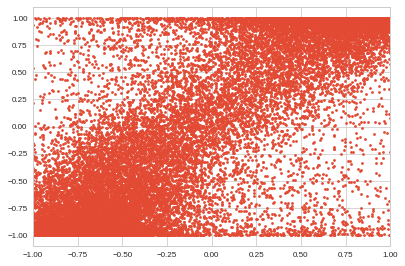

In [ ]:
#@title ### Sample Predictions v Targets Plot { form-width: "30%" }
plt.plot(predictions.sample(1).numpy()[0,:,0],
         tf.expand_dims(target.merge_dims(0,-2),0).numpy()[0,:,0],
         '.')
plt.xlim((-1,1))
#target.numpy().shape